# Lleva a cabo una Prueba Inicial del Modelo Entrenado con TF 2 viendo los objetos detectados en las imágenes de validación, también hace una prueba del OCR de los objetos (opcional)

0) Preparar ambiente e instalar paquetes:

In [1]:
#@title Clonar el repositorio de modelos de TF si no está ya disponible
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2908, done.
remote: Counting objects: 100% (2908/2908), done.
remote: Compressing objects: 100% (2436/2436), done.
remote: Total 2908 (delta 735), reused 1296 (delta 434), pack-reused 0
Receiving objects: 100% (2908/2908), 32.94 MiB | 28.68 MiB/s, done.
Resolving deltas: 100% (735/735), done.


In [2]:
#@title Instalar el Object Detection API
# Nota: si dice que faltan librerías, ignorar (funciona bien igual) 
#       sino volverlo a ejecutar esta celda para que reinistale y entonces dice todo "successfully"
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1665159 sha256=8a92c4d263cb07f94ad96897f16e1fa8cf1b438f1370267e101147398154a9a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-895f3p96/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=936a39d31a3c4d515dcbce75be6653e408caa17fd6ffba0fb9e9461cf1bc2709
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for avro-python3: filename=avro_python3-1.9.2.1-py3-none-any.whl size=43512 sha256=3e8ad4c2be5d960a60fa05313fbdab51dba6887616d5817629ac9b1f2d09f2b1
  Stored in directory: /root/.cache/pip/wheels/bc/49/5f/fdb5b9d85055c478213e0158ac122b596816149a02d82e0ab1
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78546 sha256=0d2a3e0cd1b8ba85990e88fb56a7eee8128c4ac4813bdf92d

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
#@title Baja e instala los paquetes de Tesseract-OCR (opcional, sólo si se quiere probar OCR)
!pip install pytesseract
!sudo apt install tesseract-ocr

  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14072 sha256=4b385202c2cc73d7b562964c4fe8cc53934a7f2d485364a5e5122c5c51b6ef87
  Stored in directory: /root/.cache/pip/wheels/a4/89/b9/3f11250225d0f90e5454fcc30fd1b7208db226850715aa9ace
Successfully built pytesseract
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http:/


1) Cargar librerías:

In [4]:
#@title Cargar Librerías
import os
import os.path
import sys
import numpy as np
from random import sample

import tensorflow as tf

from IPython.display import Image, display
from PIL import Image as ImPIL

import csv

print ("Librerías cargadas.")

Librerías cargadas.


2) Montar el Drive:

In [13]:
#@title Montar Google Drive
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [9]:
#@title Definir configuración de directorios local en Google Drive
drive_path = '/content/gdrive/My Drive/GEMIS/objDetectionCursogramas' #@param {type:"string"}
drive_subdir_datos = '/Cursogramas' #@param {type:"string"}
drive_subdir_modelo = '/TF_model_prueba2' #@param {type:"string"}
data_dir_path = drive_path + drive_subdir_datos
model_drive_path = drive_path + drive_subdir_modelo

print("Configuración de archivos definida.")

Configuración de archivos definida.


3) Cargar el modelo entrenado:

In [10]:
#@title Cargar el modelo de object detection entrenado y define funciones auxiliares
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# carga el modelo exportado 
ModelObjDetEntrenado = model_drive_path + '/saved_model'
detection_model = tf.saved_model.load(str(ModelObjDetEntrenado))
print("\nModelo objDetector cargado: [", ModelObjDetEntrenado, "]: ", detection_model)

# archivo con lista de clases para reconocer 
labelMapFile = model_drive_path + '/label_map.pbtxt'

label_map = label_map_util.load_labelmap(labelMapFile)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)
print("\nDefinición de Clases cargada: [", labelMapFile, "]: ", len(category_index))

# Size, in inches, of the output images.
##IMAGE_SIZE = (12, 8)
##print("\nIMAGE SIZE: ",  IMAGE_SIZE)

## funciones auxiliares

# función auxiliar para conversión de la imagen ( NO SE USA )
#def load_image_into_numpy_array(image):
#    (im_width, im_height) = image.size
#    return np.array(image.getdata()).reshape(
#        (im_height, im_width, 3)).astype(np.uint8)


# función auxiliar para procesar la imagen con el modelo
def run_inference_for_single_image(model, image_np):   
    # fuerza conversión a array por las dudas
    image_np = np.asarray(image_np) 
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                  for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    # Handle models with masks:
    if 'detection_masks' in output_dict:
      # Reframe the the bbox mask to the image size.
      detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                output_dict['detection_masks'], output_dict['detection_boxes'],
                image.shape[0], image.shape[1])      
      detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                        tf.uint8)
      output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
      
    return output_dict

# función auxiliar para mostrar resultados de procesar la imagen con el modelo
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    line_thickness = 8,
                    min_score = 0.8):

  # genera una copia de la imagen
  image_np_with_annotations = image_np.copy()

  # en la copia marca los objetos detectados
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=100,
      line_thickness=line_thickness,
      min_score_thresh=min_score,
      agnostic_mode=False)

  # muestra la copia de la imagen con los objetos detectados
  display(ImPIL.fromarray(image_np_with_annotations))  
  #print("-- objetos detectados: ", len(classes), "\n")  # siempre son 300

print("\nFunciones Auxiliares definidas.")


Modelo objDetector cargado: [ /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/TF_model_prueba2/saved_model ]:  <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f3e6db96550>

Definición de Clases cargada: [ /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/TF_model_prueba2/label_map.pbtxt ]:  22

Funciones Auxiliares definidas.


In [15]:
#@title Carga la configuración de los símbolos del Cursograma (opcional, sólo se quiere para usar OCR)

# carga la información de un archivo CSV
##model_drive_path
config_simbolos_file = model_drive_path + '/simbolos_config.csv'
##config_simbolos_file = drive_path + model_drive_path + '/simbolos_config.csv'
with open(config_simbolos_file, mode='r') as csvfile:
    lineasCSV = list(csv.reader(csvfile))

# procesa el archivo CSV 
# pero sólo levante lo de OCR
auxList = []
for l in lineasCSV:
  # si no se debe ignorar el simbolo
  if l[0][0] != "#":     
      # carga la configuración del símbolo (aunque se ignore en la comparación)
      # campo clave: nombre - valores: [descripción, claseAgrupa, ignora?, cambiarAreaY?, cambiarAreaX?, OCRconfig, OCRcropDesp] 
      OCRconfig = int(l[6])
      if OCRconfig <= 0:
        # si no tiene definido que haga el OCR, fuerza a que lo haga
        OCRconfig = 9
      auxList.append( ( l[0], [ OCRconfig, l[7] ] ) )

# genera dicccionario de la configuración de símbolos
config_simbolos = dict(auxList)

print(">Configuración de símbolos: ")
print("  cargada de [", config_simbolos_file, "] ")
print("  valores: nombre + [OCRconfig, OCRcropDesp] ] ")
print("  ", config_simbolos)

# constantes de posicion de configuraciones
config_posOCRconfig = 0
config_posOCRcropDesp = 1

>Configuración de símbolos: 
  cargada de [ /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/TF_model_prueba2/simbolos_config.csv ] 
  valores: nombre + [OCRconfig, OCRcropDesp] ] 
   {'archivoDefinitivo': [9, '-'], 'archivoTransitorio': [9, '-'], 'conector_comienzoCorte': [9, '15*15*30*30'], 'conector_reanudacionCorte': [9, '30*30*15*15'], 'control': [9, '13*13*13*13'], 'decision': [9, '13*13*13*13'], 'demora': [9, '-'], 'destruccion': [9, '-'], 'documento': [6, '10*10*6*3'], 'documentoElectronico': [6, '10*10*6*3'], 'operacion': [9, '15-15-15-15'], 'proceso': [9, '13-13-13-13'], 'procesoNoRelevado': [9, '-'], 'temporalidad': [9, '1*-15*1*61'], 'trasladoDeInformacion': [9, '-'], 'trasladoDeInformacion_vertical': [9, '-'], 'trasladoDeInformacion_horizontal': [9, '-'], 'actualizacionLogica_flecha': [9, '-'], 'consultaLogica_flecha': [9, '-'], 'separador_area_interna': [9, '-'], 'separador_area_externa': [9, '-']}


In [16]:
#@title Definir función auxiliar para hacer el OCR (opcional) { run: "auto" }
import pytesseract

# función auxiliar para realizar el OCR de los símbolos que corresponda
# devuelve el texto obtenido del OCR
# nota: está es la misma función que usa el Evaluador
def hacerOCR(imageCargada, class_name, nuevoRangoIm):
    resOCR = ''
    if class_name in config_simbolos and config_simbolos[class_name][config_posOCRconfig]>0:
    # si es una clase que se procesa el OCR
        # si es una clase que se procesa el OCR
        if config_simbolos[class_name][config_posOCRcropDesp]!="" and config_simbolos[class_name][config_posOCRcropDesp]!="-" and config_simbolos[class_name][config_posOCRcropDesp]!="*":
          # si corresponde achicar la imagen
          cropOCRdespPorc = config_simbolos[class_name][config_posOCRcropDesp].split("*")
          if len(cropOCRdespPorc)==4:
              # toma de la configuración los valores para reducir el tamaño de la subimagen
              imAncho = (nuevoRangoIm[2] - nuevoRangoIm[0])
              imAlto = (nuevoRangoIm[3] - nuevoRangoIm[1])
              nuevoRangoIm = (  nuevoRangoIm[0] + (imAncho * int(cropOCRdespPorc[0]) ) // 100,
                                nuevoRangoIm[1] + (imAlto * int(cropOCRdespPorc[1]) ) // 100,
                                nuevoRangoIm[2] - (imAncho * int(cropOCRdespPorc[2]) ) // 100,
                                nuevoRangoIm[3] - (imAlto *  int(cropOCRdespPorc[3]) ) // 100
                                    )

        # toma la parte de la imagen que corresponde al objeto             
        imDetObj = imageCargada.crop( nuevoRangoIm )
        if muestraDetalleDebug:
            display( imDetObj )

        # procesa el OCR y formatea
        resOCR = pytesseract.image_to_string(imDetObj, lang='eng', config='--psm '+str(config_simbolos[class_name][config_posOCRconfig]))
        resOCR = resOCR.replace("\n", "").upper().strip()
        if muestraDetalleDebug:
            print("   hacerOCR -- Parámetros: class_name (", class_name, ")  - nuevoRangoIm (", nuevoRangoIm, ") --> resOCR: ", resOCR)

    return resOCR

print("Función auxiliar hacerOCR definida.")

Función auxiliar hacerOCR definida.


4) Llevar a cabo la detección de objetos sobre las imágenes de validación:

In [21]:
#@title Definir imágenes a utilizar

considerar_imagenes = "Todas" #@param ["Todas", "Sin DA", "Con DA"]

# define la carpeta donde están las imágenes para procesar
fuente_imagenes = '/validation/images' #@param ['/validation/images', '/train/images', '/Generados', '/Para-Evaluar', '/Diagramas-Enunciados' ]
dirTest = data_dir_path + fuente_imagenes

# levanta las imágenes de prueba para procesar
process_FileNames = [ fn for fn in os.listdir( dirTest ) if fn.endswith('.png') or fn.endswith('.jpg') ]
if considerar_imagenes == "Sin DA":
  process_FileNames = [ fn for fn in process_FileNames if not fn.startswith('da') ]
elif considerar_imagenes == "Con DA":
  process_FileNames = [ fn for fn in process_FileNames if fn.startswith('da') ]
  
print("> Imágenes a probar: ", len(process_FileNames))

> Imágenes a probar:  346


In [25]:
#@title Tomar una muestra de las imágenes (si es necesario o se quiere) { run: "auto" }

porcMuestraImagenesProcesar = 10  #@param {type:"slider", min:0, max:100, step:5}
if porcMuestraImagenesProcesar>=0 and porcMuestraImagenesProcesar<100:
  cantProcesar = int(len(process_FileNames)*porcMuestraImagenesProcesar/100)
  if cantProcesar<=0:
    cantProcesar = 1
  process_FileNames = sample(process_FileNames, cantProcesar)
print("> Imágenes a probar: ", len(process_FileNames))

> Imágenes a probar:  3


In [23]:
#@title Definir funciones especiales para preparación de imágenes para usar antes de  aplicar modelo
import cv2
import PIL
from PIL import ImageEnhance

#@markdown Preparación de imágenes con ajustes (opcional):
imagen_ajuste_Contraste =   0#@param {type:"integer"}
imagen_ajuste_Brillo =   0#@param {type:"integer"}
imagen_ajuste_Sharpen =  0 #@param {type:"integer"}
imagen_ajuste_Saturation =  0 #@param {type:"integer"}
ajustes_usar_imagen = []
if imagen_ajuste_Contraste != 0:
  ajustes_usar_imagen.append( ["Contrast", imagen_ajuste_Contraste] )
if imagen_ajuste_Brillo != 0:
  ajustes_usar_imagen.append( ["Brightness", imagen_ajuste_Brillo] )
if imagen_ajuste_Sharpen != 0:
  ajustes_usar_imagen.append( ["Sharpen", imagen_ajuste_Sharpen] )
if imagen_ajuste_Saturation != 0:
  ajustes_usar_imagen.append( ["Saturation", imagen_ajuste_Saturation] )

#@markdown Preparación de imágenes con filtros (opcional):
imagen_filtro1_aplicar = "-" #@param ["-", "Averaging Blur filter", "Median Blur filter", "Gaussian filter", "Bilateral filter", "Laplacian filter"]
imagen_filtro1_valor =   5#@param {type:"integer"}
imagen_filtro2_aplicar = "-" #@param ["-", "Averaging Blur filter", "Median Blur filter", "Gaussian filter", "Bilateral filter", "Laplacian filter"]
imagen_filtro2_valor =   3#@param {type:"integer"}
imagen_filtro3_aplicar = "-" #@param ["-", "Averaging Blur filter", "Median Blur filter", "Gaussian filter", "Bilateral filter", "Laplacian filter"]
imagen_filtro3_valor =   3#@param {type:"integer"}
filtros_usar_imagen = []
if (imagen_filtro1_aplicar != "-"):
  filtros_usar_imagen.append( [imagen_filtro1_aplicar, imagen_filtro1_valor] )
if (imagen_filtro2_aplicar != "-"):
  filtros_usar_imagen.append( [imagen_filtro2_aplicar, imagen_filtro2_valor] )
if (imagen_filtro3_aplicar != "-"):
  filtros_usar_imagen.append( [imagen_filtro3_aplicar, imagen_filtro3_valor] )

def aplicarAjustesImagen(img, listaAjustes, debug=False):
  if img is None:
    return img
  if (len(listaAjustes)==0):
    return img
  nImg = img
  for tf, vf in listaAjustes:
    if "Contrast" in tf:
      # aumenta el Contraste en vf unidades
      converter = ImageEnhance.Contrast(nImg)
      nImg = converter.enhance(vf)
      if debug:
        print("  aplicarAjustesImagen: Contrast con valor ", vf)
    elif "Brightness" in tf:
      # aumenta el Brillo en vf unidades
      converter = ImageEnhance.Brightness(nImg)
      nImg = converter.enhance(vf)
      if debug:
        print("  aplicarAjustesImagen: Brightness con valor ", vf)      
    elif "Sharpen" in tf:
      # aumenta el 'Sharpen' en vf unidades
      converter = ImageEnhance.Sharpness(nImg)
      nImg = converter.enhance(vf)    
      if debug:
        print("  aplicarAjustesImagen: Sharpness con valor ", vf)      
    elif ("Saturation" in tf) or ("Color" in tf):
      # aumenta el 'Saturation'en vf unidades
      converter = ImageEnhance.Color(nImg)
      nImg = converter.enhance(vf)      
      if debug:
        print("  aplicarAjustesImagen: Saturation / Color con valor ", vf)            
    else:
        if debug:
          print("  aplicarAjustesImagen: tipo ", tf," con valor ", vf, "descartado!")
  # devuelve la imagen resultante
  return nImg      

def aplicarFiltrosImagen(imgNP, listaFiltros, debug=False):
  if imgNP is None:
    return img
  if (len(listaFiltros)==0):
    return imgNP
  nImg = imgNP
  for tf, vf in listaFiltros:
    if ("Median" in tf) and ("Blur" in tf):
      # aplica el filtro 'Median Blur'
      nImg = cv2.medianBlur(nImg, vf)
      if debug:
        print("  aplicarFiltrosImagen: MedianBlur Filter con valor ", vf)
    elif ("Blur" in tf) or ("Averaging" in tf):
      # aplica el filtro 'Blur' / 'Averaging'
      nImg = cv2.blur(nImg, (vf,vf))
      if debug:
        print("  aplicarFiltrosImagen: Blur Filter con valor ", vf)
    elif ("Sharpen" in tf) or ("Gaussian" in tf):
      # aplica el filtro 'Gaussian'
      nImg = cv2.GaussianBlur(nImg, (vf,vf), 0)      
      if debug:
        print("  aplicarFiltrosImagen: Sharpen / GaussianBlur con valor ", vf)
    elif "Bilateral" in tf:
      # aplica el filtro 'Bilateral filter'
      nImg = cv2.bilateralFilter(nImg, vf, 10, 10)            
      if debug:
        print("  aplicarFiltrosImagen: Bilateral Filter con valor ", vf)
    elif "Laplacian" in tf:
      # aplica el filtro 'Laplacian'
      nImg = cv2.Laplacian(nImg, vf, cv2.CV_64F)             
      if debug:
        print("  aplicarFiltrosImagen: Laplacian Filter con valor ", vf)
    else:
        if debug:
          print("  aplicarFiltrosImagen: tipo ", tf," con valor ", vf, "descartado!")
  # devuelve el array de la imagen resultante
  return nImg      

# función auxiliar para ajustar colores de la imagen
def ajustarColoresImagen(img, tipoColores, thresholdBN=0):
  if "Grises" in tipoColores:
    # Convierte la imagen a escala de grises 
    img = img.convert('L')
    img = img.convert('RGB')
  elif ("B&N" in tipoColores) or ( ("Blanco" in tipoColores) and ("Negro" in tipoColores)):
    if thresholdBN > 0:
      # Convierte la imagen a Blanco & Negro usando un valor de threshold especial
      fnBW = (lambda x : 255 if x >= thresholdBN else 0)
      img = img.convert('L').point(fnBW, mode='1')
      img = img.convert('RGB')
    else: #  "Blanco & Negro"
      # Convierte la imagen a Blanco & Negro normal (pierde detalle)
      img = img.convert('1')
  # siempre devuelve tipo RGB para dejarlo con 3 canales de profundidad
  return img.convert('RGB')

print("Funciones para preparación de imágenes definidas.")

Funciones para preparación de imágenes definidas.




>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/validation/images/c_SFaRV_00004.png : 
  Tamaño de la imagen:  (1123, 794, 3) 


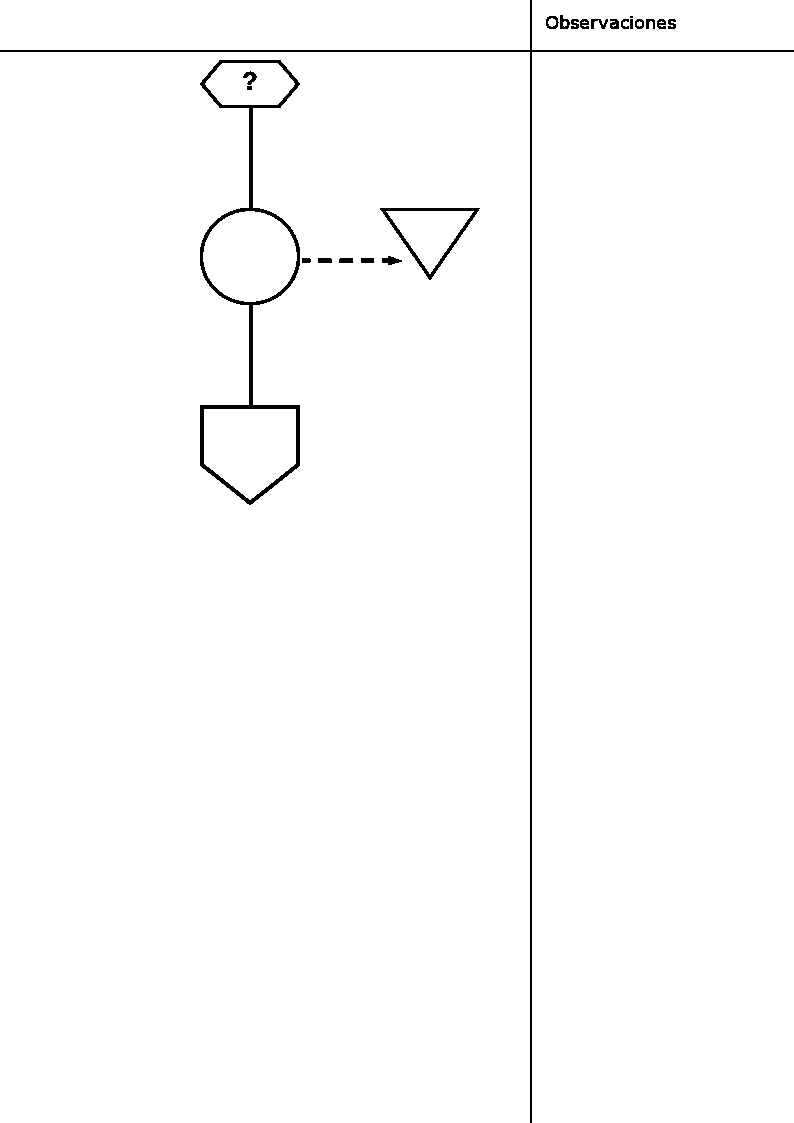


  # Cantidad de objetos detectados: >=MinProb: 0 / <MinProb: 300 



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/validation/images/c_SPRS_00051f.png : 
  Tamaño de la imagen:  (1123, 794, 3) 


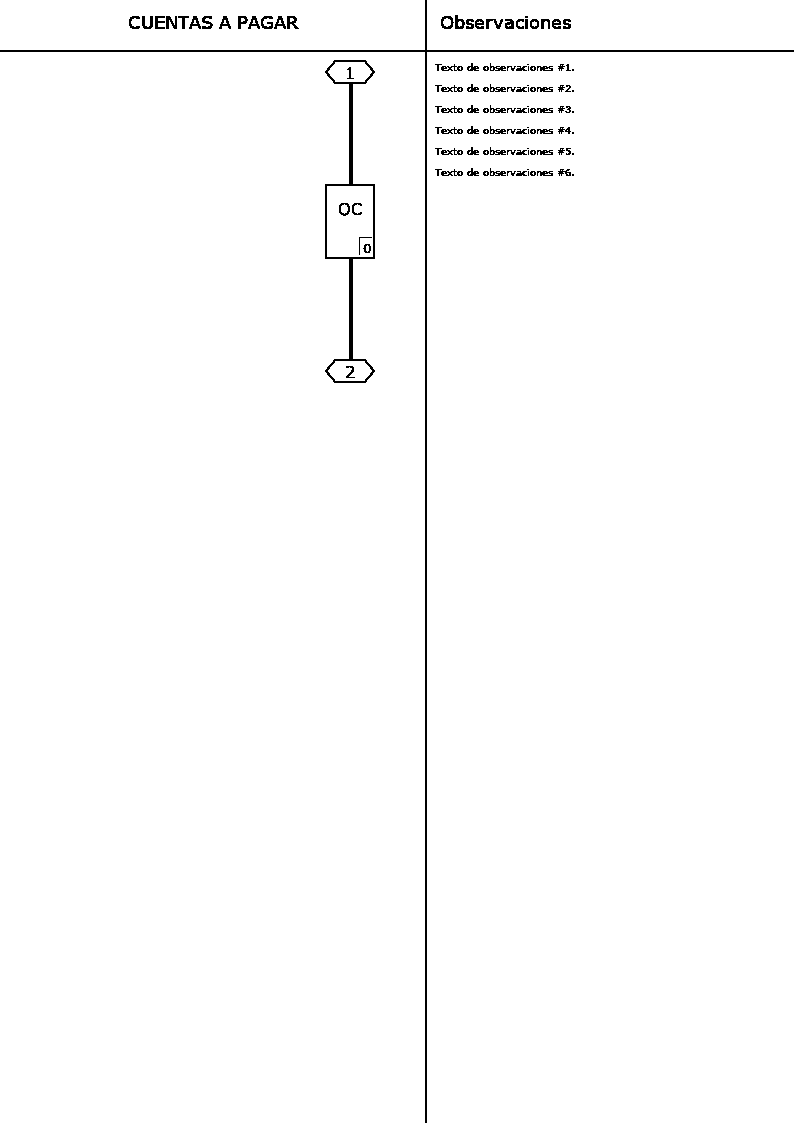


  # Cantidad de objetos detectados: >=MinProb: 0 / <MinProb: 300 



>  /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/Cursogramas/validation/images/da_c_SFdRS_00061fr-ev45.png : 
  Tamaño de la imagen:  (505, 794, 3) 


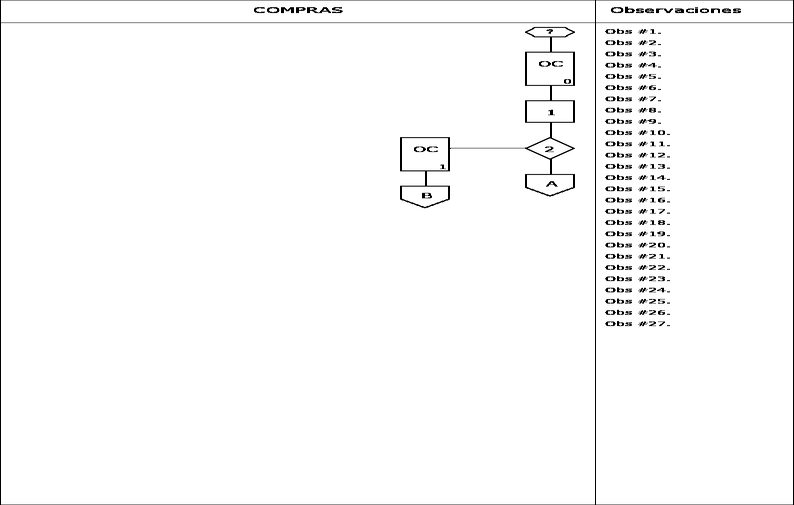


  # Cantidad de objetos detectados: >=MinProb: 0 / <MinProb: 300 




  ## Cantidad total de objetos detectados: >=MinProb: 0 / <MinProb: 900 

  ## Promedio de cantidad de objetos detectados: >=MinProb: 0.00 / <MinProb: 300.00 






In [28]:
#@title Procesar imágenes para mostrar los objetos detectados por el modelo

#@markdown Minima probabilidad a usar en modelo:
#minimaProbabilidadObjectDetection = 90 #@param {type:"slider", min:1, max:100, step:1.0}
minimaProbabilidadObjectDetection = 50 #@param {type:"slider", min:1, max:100, step:1.0}
minProbObjDet = minimaProbabilidadObjectDetection / 100.0

#@markdown Preparación de imágenes:
tipo_imagen_usar = "Escala de Grises" #@param ["Color", "Escala de Grises", "Blanco & Negro", "B&N con threshold"]
tipo_imagen_BN_threshold = 230 #@param {type:"slider", min:1, max:255, step:1.0}
usar_funciones_especiales_preparacion_imagen = False #@param {type:"boolean"}

#@markdown Otros Parámetros:
muestraObjDetectadosEnImagen = True #@param {type:"boolean"}
contarObjetosDetectados = True #@param {type:"boolean"}
# define si muestra detalle o no
muestraDetalleSubImagenes = False #@param {type:"boolean"}
# define si ejecuta OCR en sub-imagenes
EjecutaOCRenSubImagenes = False #@param {type:"boolean"}
muestraOCRSubImagenes = EjecutaOCRenSubImagenes
muestraDetalleDebug = False #@param {type:"boolean"}

# totalizadores
cantObjetosDetectadosTotal_OkProb = 0
cantObjetosDetectadosTotal_BajoProb = 0

# procesa las imágenes 
for fn in process_FileNames:

  # define archivo a procesar y generar
  imagenProcesar = dirTest + '/' + fn

  print("\n\n> ", imagenProcesar, ": ")
  
  # open file to process
  imageCargada = ImPIL.open(imagenProcesar) 

  # ajusta tipo color imagen
  imageCargada = ajustarColoresImagen(imageCargada, tipo_imagen_usar, tipo_imagen_BN_threshold)

  # obtiene el tamaño de la imagen
  imCargada_ancho, imCargada_alto = imageCargada.size

  # aplica los ajustes seleccionados
  if usar_funciones_especiales_preparacion_imagen:
    if len(ajustes_usar_imagen) > 0:
      imageCargada = aplicarAjustesImagen(imageCargada, ajustes_usar_imagen, muestraDetalleDebug)
    else:
      if muestraDetalleDebug:
        print("  - No se ejecuta aplicarAjustesImagen ")

  # convierte la imagen a un array 
  image_np = np.array(imageCargada)

  # aplica los filtros seleccionados
  if usar_funciones_especiales_preparacion_imagen:
    if len(filtros_usar_imagen) > 0:
      imageCargada = aplicarFiltrosImagen(image_np, filtros_usar_imagen, muestraDetalleDebug)
    else:
      if muestraDetalleDebug:
        print("  - No se ejecuta aplicarFiltrosImagen ")
 
  # Obtiene el tamaño de la imagen
  print("  Tamaño de la imagen: ", image_np.shape, "")

  # Procesa el array de la imagen con el modelo cargado
  output_dict = run_inference_for_single_image(detection_model, image_np)

  if muestraObjDetectadosEnImagen:
    # muestra los resultados
    plot_detections(
        image_np = image_np,
        boxes = output_dict['detection_boxes'],
        classes = output_dict['detection_classes'],
        scores = output_dict['detection_scores'],
        category_index = category_index,
        min_score = minProbObjDet)

  cantObjetosDetectadosIm_OkProb = 0
  cantObjetosDetectadosIm_BajoProb = 0
  
  if muestraDetalleSubImagenes or muestraOCRSubImagenes or contarObjetosDetectados:   

      # procesa los objetos detectados
      for detClass, detBox, detScore in zip(  output_dict['detection_classes'], output_dict['detection_boxes'], output_dict['detection_scores'] ):

        class_name = category_index[detClass]['name']

        # como las coordenadas están normalizadas las debe convertir 
        # teniendo en cuenta el tamaño de la imagen
        # además notar que vienen datas en otro orden
        # - detBox = (ini alto, ini ancho, fin alto, fin ancho)
        # - nuevoRangoIn = (ini ancho x1, ini alto y1, fin ancho x2, fin alto y2)    
        nuevoRangoIm = [detBox[1] * imCargada_ancho, 
                        detBox[0] * imCargada_alto,
                        detBox[3] * imCargada_ancho,
                        detBox[2] * imCargada_alto]

        # si el objeto detectado tiene un puntaje superior o igual al mínimo
        if detScore >= minProbObjDet:

            # incrementa la cantidad de objetos detectados con probabilidad OK
            if contarObjetosDetectados:
              cantObjetosDetectadosIm_OkProb = cantObjetosDetectadosIm_OkProb + 1

            if muestraDetalleSubImagenes or muestraOCRSubImagenes:

              # calcula un valor para poder ordenar las figuras de arriba a abajo y izquierda a derecha
              centroideIm = nuevoRangoIm[1]*100000+nuevoRangoIm[0]

              # extrae la subimagen de acuerdo al área indicada por el detector        
              imDetObj = imageCargada.crop( nuevoRangoIm )
              imAncho, imAlto = imDetObj.size

              # muestra la sub-imagen
              print("\n")
              if muestraDetalleSubImagenes:              
                display( imDetObj )

              # muestra resultados
              print("    - detecta ", class_name, " : ", detScore*100, "% : ", detBox, "con centroide: ", centroideIm)

              # devuelve resultados del OCR
              if EjecutaOCRenSubImagenes:
                resOCR = hacerOCR(imageCargada, class_name, nuevoRangoIm)
                print("    * resOCR: ", resOCR)
        
        else:
              # incrementa la cantidad de objetos detectados con probabilidad menor al mínimo
              if contarObjetosDetectados:
                cantObjetosDetectadosIm_BajoProb = cantObjetosDetectadosIm_BajoProb + 1

              if muestraDetalleSubImagenes or muestraOCRSubImagenes:
                if detScore >= 0.4:
                  print("-- objeto descartado por bajo score: ", class_name, "(", detScore*100, "%) en ", nuevoRangoIm)
    
  if contarObjetosDetectados:
    # muestra totales de la imagen
    print("\n  # Cantidad de objetos detectados: >=MinProb: {0} / <MinProb: {1} \n".format(cantObjetosDetectadosIm_OkProb, cantObjetosDetectadosIm_BajoProb))
    cantObjetosDetectadosTotal_OkProb = cantObjetosDetectadosTotal_OkProb + cantObjetosDetectadosIm_OkProb
    cantObjetosDetectadosTotal_BajoProb = cantObjetosDetectadosTotal_BajoProb + cantObjetosDetectadosIm_BajoProb

# muestra totales generales
print("\n\n")
print("  ## Cantidad total de objetos detectados: >=MinProb: {0} / <MinProb: {1} \n".format(cantObjetosDetectadosTotal_OkProb, cantObjetosDetectadosTotal_BajoProb))
if len(process_FileNames) > 0:
  print("  ## Promedio de cantidad de objetos detectados: >=MinProb: {0:.2f} / <MinProb: {1:.2f} \n".format((cantObjetosDetectadosTotal_OkProb/len(process_FileNames)), (cantObjetosDetectadosTotal_BajoProb/len(process_FileNames))))
print("\n\n")
